In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
import os
import sys
import argparse
import ipykernel
import math
import datetime

import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

#Time series modelling libraries
import statsmodels
from statsmodels.tsa.api import adfuller, seasonal_decompose, VAR, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import arch
from arch import arch_model

#LSTM modelling libraries
import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [72]:
#read the data 
data = pd.read_csv('tsla_2025.csv')

#format date column from object to date format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

#copy of main data 
time_series_data = data.copy()

#set date column as index 
time_series_data.set_index('Date', inplace=True)

#extract month, year from the data
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year


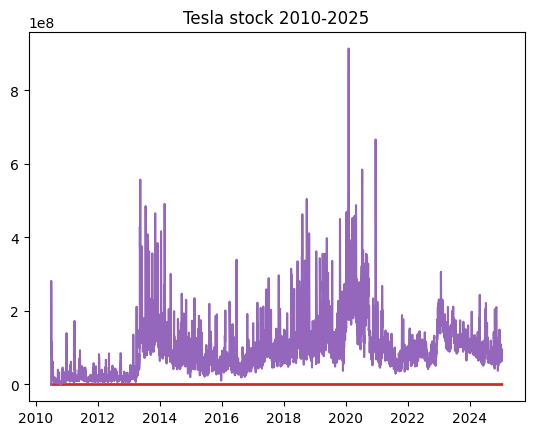

In [73]:
mp.title("Tesla stock 2010-2025")
mp.plot(time_series_data)
mp.show()

Daily seasonality for Tesla stock closing price


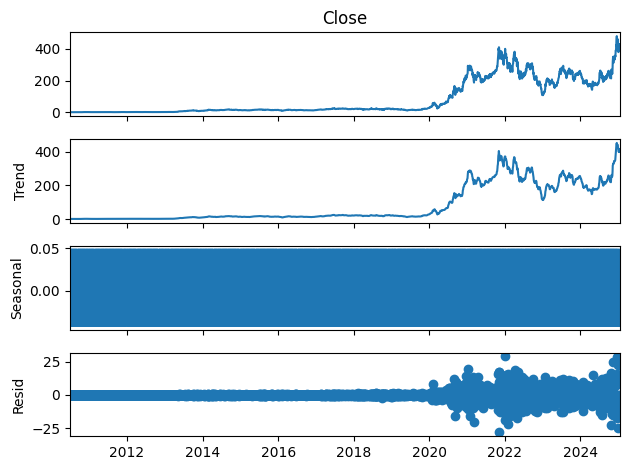

In [74]:
#business days 5 , we have data from 2010-2025 so i can check weekly seasonality (5), monthly seasonality (21), yearly seasonality (252) 

#daily seasonality for stock closing price
print("Daily seasonality for Tesla stock closing price")
daily_sd_open = seasonal_decompose(time_series_data['Close'], model='additive', period=5)
daily_sd_open.plot()
mp.show()

Monthly seasonality for Tesla stock closing price


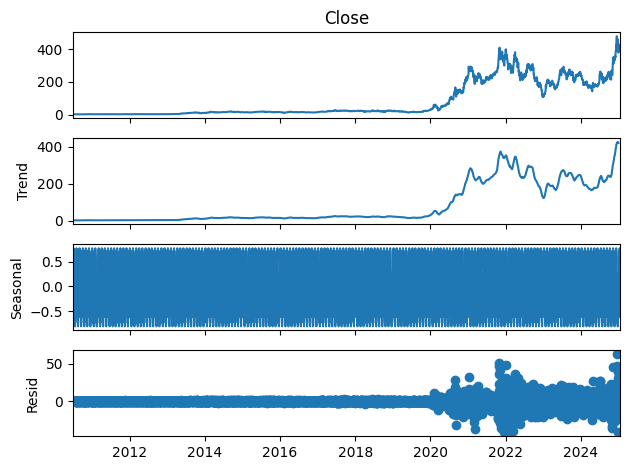

In [75]:
#monthly seasonality for closing price
print("Monthly seasonality for Tesla stock closing price")
monthly_sd_open = seasonal_decompose(time_series_data['Close'], model='additive', period=21)
monthly_sd_open.plot()
mp.show()

Yearly seasonality for Tesla stock closing price


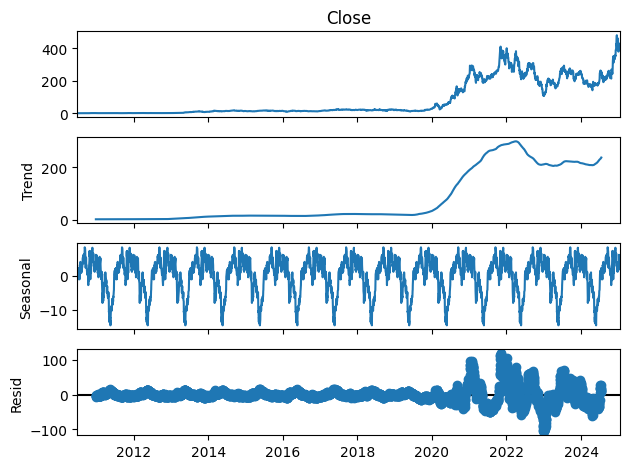

In [76]:
#yearly seasonality for closing price
print("Yearly seasonality for Tesla stock closing price")
yearly_sd_open = seasonal_decompose(time_series_data['Close'], model='additive', period=252)
yearly_sd_open.plot()
mp.show()

##### There is monthly and yearly seasonality for closing price. 

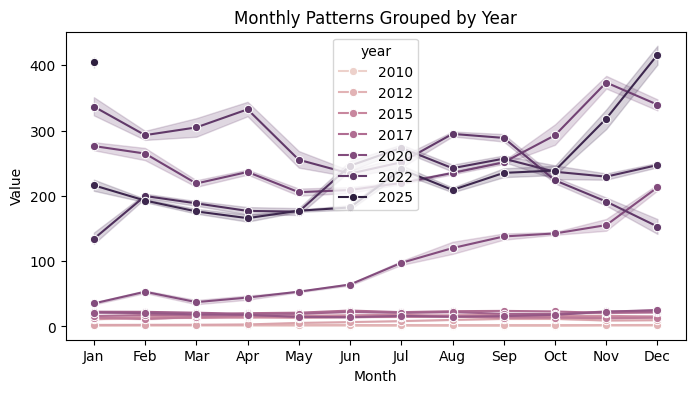

In [77]:
# Create a lineplot grouped by 'month' and 'year'
mp.figure(figsize=(8, 4))
sb.lineplot(data=data, x='month', y='Close', hue='year', marker='o')

# Add labels and title
mp.title('Monthly Patterns Grouped by Year')
mp.xlabel('Month')
mp.ylabel('Value')
mp.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
mp.show()

Monthly seasonality for Tesla stock units / Volume


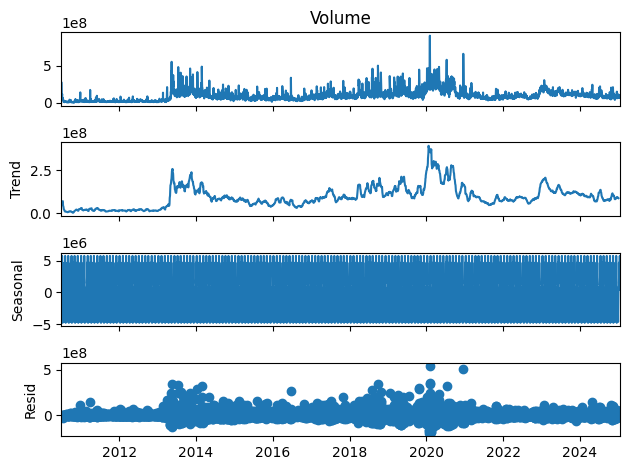

In [78]:
#monthly seasonality for Volume
print("Monthly seasonality for Tesla stock units / Volume")
monthly_sd_volume = seasonal_decompose(time_series_data['Volume'], model='additive', period=21)
monthly_sd_volume.plot()
mp.show()

Yearly seasonality for Tesla stock opening price


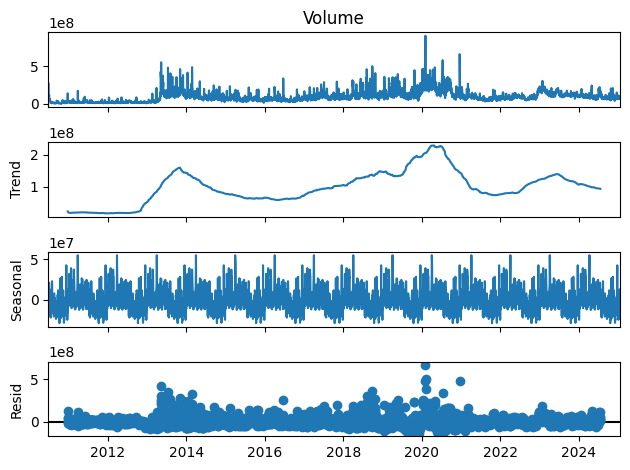

In [79]:
#yearly seasonality for Volume
print("Yearly seasonality for Tesla stock opening price")
yearly_sd_volume = seasonal_decompose(time_series_data['Volume'], model='additive', period=252)
yearly_sd_volume.plot()
mp.show()

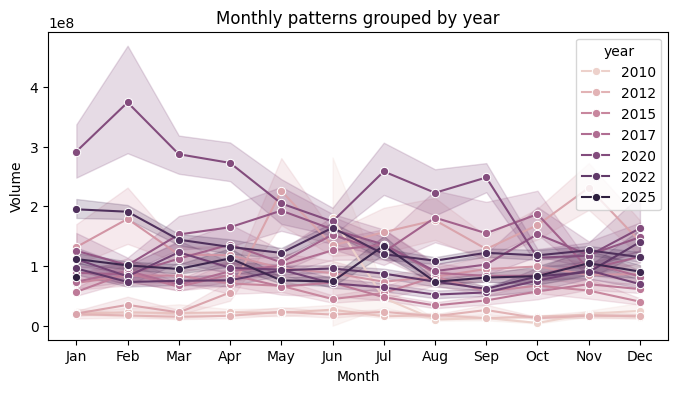

In [80]:
# Create a lineplot grouped by 'month' and 'year'
mp.figure(figsize=(8, 4))
sb.lineplot(data=data, x='month', y='Volume', hue='year', marker='o')

# Add labels and title
mp.title('Monthly patterns grouped by year')
mp.xlabel('Month')
mp.ylabel('Volume')
mp.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
mp.show()

In [81]:
adfuller(time_series_data['Close'])

#data is not stationery

(np.float64(0.07956265383709658),
 np.float64(0.964637720717346),
 28,
 3634,
 {'1%': np.float64(-3.432150749908472),
  '5%': np.float64(-2.8623356709244043),
  '10%': np.float64(-2.5671935478749135)},
 np.float64(22260.440214848502))

In [82]:
adfuller(time_series_data['Volume'])

#data is stationery

(np.float64(-3.7925612541271336),
 np.float64(0.002984346659305391),
 27,
 3635,
 {'1%': np.float64(-3.432150254165979),
  '5%': np.float64(-2.8623354519441797),
  '10%': np.float64(-2.567193431297053)},
 np.float64(138194.7564189739))

<Figure size 600x300 with 0 Axes>

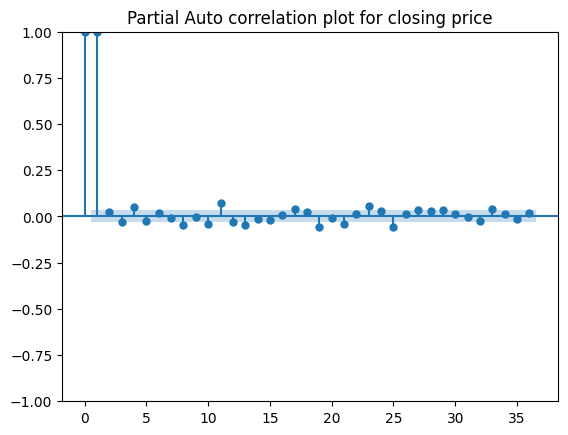

In [83]:
mp.figure(figsize=(6,3))
plot_pacf(time_series_data['Close'], title='Partial Auto correlation plot for closing price')
mp.show()

<Figure size 600x300 with 0 Axes>

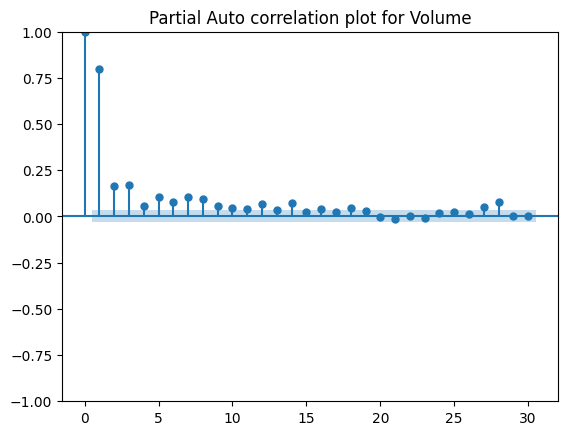

In [84]:
mp.figure(figsize=(6,3))
plot_pacf(time_series_data['Volume'], title='Partial Auto correlation plot for Volume', lags=30)
mp.show()

In [85]:
#define the training size
training_size = int(len(time_series_data)*0.70)

#split the data into train, test
train_data = time_series_data[:training_size]
test_data = time_series_data[training_size:]

In [86]:
import warnings
warnings.filterwarnings("ignore")

ARIMA models results:

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                 2564
Model:                 ARIMA(2, 0, 0)   Log Likelihood              -49156.708
Date:                Fri, 18 Apr 2025   AIC                          98321.417
Time:                        14:21:00   BIC                          98344.814
Sample:                             0   HQIC                         98329.900
                               - 2564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.255e+07    2.2e-12   4.22e+19      0.000    9.25e+07    9.25e+07
ar.L1          0.6851      0.009     74.599      0.000       0.667       0.703
ar.L2          0.1489      0.

<Axes: >

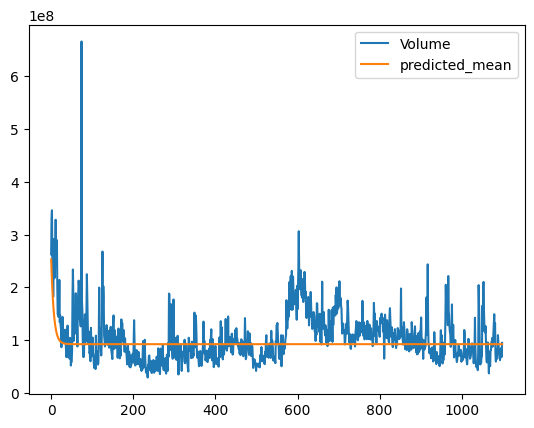

In [ ]:
#Arima model to predict volume

#build the model and fit on train data
arima_mod = ARIMA(train_data['Volume'], order=(2,0,0))
arima_mod = arima_mod.fit()

#print the results
print("ARIMA models results:")
print()
print(arima_mod.summary())

#define the start and end index in order to make predictions 
start = len(train_data)
end = len(train_data+test_data)-1

#make predictions on test data 
arima_predictions = arima_mod.predict(start, end)

#error metric mae, rmse, mape
arima_mae = mean_absolute_error(test_data['Volume'], arima_predictions)
arima_rmse = math.sqrt(mean_squared_error(test_data['Volume'], arima_predictions))
arima_mape = round(mean_absolute_percentage_error(test_data['Volume'], arima_predictions),2)*100
print(f'MAE is {arima_mae} and RMSE is {arima_rmse}, we can say the predictions are off by {arima_mape}%')
print()

#compare actual vs predicted
print("Actual vs Predicted")
actual_vs_predicted = pd.concat([test_data['Volume'].reset_index(drop=True), 
                                arima_predictions.reset_index(drop=True)], 
                                axis=1)
actual_vs_predicted.plot()

ARIMA models results:

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2564
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3820.291
Date:                Fri, 18 Apr 2025   AIC                           7648.581
Time:                        14:22:39   BIC                           7671.977
Sample:                             0   HQIC                          7657.064
                               - 2564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8171      0.015     55.270      0.000       0.788       0.846
ar.L2          0.0732      0.005     14.784      0.000       0.064       0.083
ma.L1         -0.8292      0.

<Axes: >

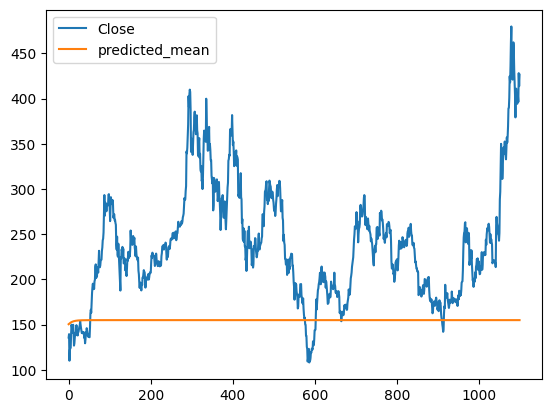

In [112]:
#Arima model to predict closing price

#build the model and fit on train data
arima_mod = ARIMA(train_data['Close'], order=(2,1,1))
arima_mod = arima_mod.fit()

#print the results
print("ARIMA models results:")
print()
print(arima_mod.summary())

#define the start and end index in order to make predictions 
start = len(train_data)
end = len(train_data+test_data)-1

#make predictions on test data 
arima_predictions = arima_mod.predict(start, end)

#error metric mae, rmse, mape
arima_mae = mean_absolute_error(test_data['Close'], arima_predictions)
arima_rmse = math.sqrt(mean_squared_error(test_data['Close'], arima_predictions))
arima_mape = round(mean_absolute_percentage_error(test_data['Close'], arima_predictions),2)*100
print(f'MAE is {arima_mae} and RMSE is {arima_rmse}, we can say the predictions are off by {arima_mape}%')
print()

#compare actual vs predicted
print("Actual vs Predicted")
actual_vs_predicted = pd.concat([test_data['Close'].reset_index(drop=True), 
                                arima_predictions.reset_index(drop=True)], 
                                axis=1)
actual_vs_predicted.plot()

In [ ]:
#Sarima model

#build the model and fit on train data
sarima_mod = SARIMAX(train_data['Volume'], order=(5,0,0), seasonal_order=(5, 0, 1, 12))
sarima_mod = sarima_mod.fit()

#print the results
print("SARIMA models results:")
print()

#define the start and end index in order to make predictions  
start = len(train_data)
end = len(train_data+test_data)-1

#make predictions on test data 
sarima_predictions = sarima_mod.predict(start, end)

#error metric mae, rmse, mape
sarima_mae = mean_absolute_error(test_data['Volume'], sarima_predictions)
sarima_rmse = math.sqrt(mean_squared_error(test_data['Volume'], sarima_predictions))
sarima_mape = round(mean_absolute_percentage_error(test_data['Volume'], sarima_predictions),2)*100
print(f'MAE is {sarima_mae} and RMSE is {sarima_rmse}, we can say the predictions are off by {sarima_mape}%')
print()

SARIMA models results:

MAE is 47693607.29928747 and RMSE is 59185954.514652446, we can say the predictions are off by 61.0%



In [89]:
#length  ---- #number of timesteps (number of data points to be considered for 1 sequence)
sequence_length = 30   

# how many sequences per batch
batch_size = 1   

#number of features in the dataset including target variable
n_features = 4

train_features_only = train_data.drop(columns=['Volume'])
train_target_only = train_data['Volume']

test_features_only = test_data.drop(columns=['Volume'])
test_target_only = test_data['Volume']

#creating sequences from train and test data, store it in a variable/s
train_sequence = TimeseriesGenerator(train_features_only, train_target_only, length = sequence_length, batch_size=1)
test_sequence = TimeseriesGenerator(test_features_only, test_target_only, length=sequence_length, batch_size=1)

#LSTM model needs input_shape = number of features, length of time steps , batch size if reqd.
model = Sequential()
model.add(LSTM(units=150, activation='relu', input_shape=(sequence_length, n_features), return_sequences=True))
model.add(LSTM(units=100, activation='relu', return_sequences=True))
model.add(LSTM(units=60, activation='relu'))
model.add(Dense(units=1))

#loss that needs to be monitored
model.compile(optimizer='adam', loss='mae')
#fit on train sequences generated
model.fit(train_sequence, epochs=25, callbacks=EarlyStopping(monitor='loss', patience=10), verbose=1)

#make predictions on test data 
lstm_predictions = model.predict(test_sequence)
lstm_predictions = pd.DataFrame(lstm_predictions)
print("LSTM predictions have been made.")

Epoch 1/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - loss: 75664504.0000
Epoch 2/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 43045532.0000
Epoch 3/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 48175916.0000
Epoch 4/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 47580092.0000
Epoch 5/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 48s 19ms/step - loss: 45333248.0000
Epoch 6/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - loss: 46415824.0000
Epoch 7/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 44780784.0000
Epoch 8/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 42637256.0000
Epoch 9/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 41458160.0000
Epoch 10/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 41216700.0000
Epoch 11/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - loss: 42915188.0000
Epoch 12/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - loss: 41127096.0000
Epoch 13/25
2534/2534 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - lo

In [90]:
# Get the true target values (actuals)
features = []
targets = []
for i in range(len(test_sequence)):
    x, y = test_sequence[i]    
    features.append(x[0][0])
    targets.append(y[0])
features = pd.DataFrame(features)
targets = pd.DataFrame(targets)

#concat features, targets
actuals = pd.concat([features, targets], axis=1, ignore_index=True)

#add columns to actuals df 
actuals.columns = [['Open', 'High', 'Low', 'Close', 'Volume']]

#error metric mae, rmse, mape
lstm_mae = mean_absolute_error(actuals['Volume'], lstm_predictions)
lstm_rmse = math.sqrt(mean_squared_error(actuals['Volume'], lstm_predictions))
lstm_mape = round(mean_absolute_percentage_error(actuals['Volume'], lstm_predictions),2)*100
print(f'MAE is {lstm_mae} and RMSE is {lstm_rmse}, we can say the predictions are off by {lstm_mape}%')
print()

MAE is 999584345.7839102 and RMSE is 1040108729.3306329, we can say the predictions are off by 1194.0%



In [99]:
#forecast into the future (20-Jan-2025 to 24-Jan-2025) for 5 business days
forecast_days = 5
batch_size = 1
n_features = 4
sequence_length = 3

#store the predictions
future_predictions = []

#create a rolling sequence
rolling_sequence = features.copy()

#loop through every day for 5 bizz days to generate predictions 
for i in range(forecast_days):
    #prepare the last 5 values as input and exclude targets 
    input_seq = rolling_sequence.iloc[-sequence_length:,:n_features].to_numpy().reshape((batch_size, sequence_length, n_features))
    print("input_seq", input_seq)
    print()

    #predict next value
    prediction = model.predict(input_seq, verbose=0)[0][0]
    print("prediction", prediction)
    print()

    future_predictions.append(prediction)
    print("future_predictions:", future_predictions)
    print()

    # Create a new row by copying the last row and updating only the target column (index 3)
    last_row = rolling_sequence.iloc[-1].copy()
    print("lastrow", last_row)
    last_row['Volume'] = prediction  # adding predicted value as last column value 
    print("last row after adding column volume:", last_row)
    print()

    # Append the new row to the rolling_sequence
    rolling_sequence = pd.concat([rolling_sequence, pd.DataFrame([last_row])], ignore_index=True)
    print("rolling sequence",rolling_sequence)
    print()


#Create an empty dataframe future_predictions_df 
future_predictions_df = pd.DataFrame()

#add date column for 5 bizz days 
future_predictions_df['Date'] = pd.date_range(start='2025-01-20', periods=5)

#add future predictions list into dataframe 
future_predictions_df['Predicted volume'] = pd.DataFrame(future_predictions)

#convert the result into csv file
future_predictions_df.to_csv('Forecast_for_future.csv', index=False)

print(f'Forecast for {forecast_days} days have been completed and saved in csv file.')

input_seq [[[336.08   345.45   334.6501 345.16  ]
  [352.38   360.     351.1501 357.09  ]
  [351.8    355.69   348.2    351.42  ]]]

prediction 27138.926

future_predictions: [np.float32(27138.926)]

lastrow 0    351.80
1    355.69
2    348.20
3    351.42
Name: 1068, dtype: float64
last row after adding column volume: 0           351.800000
1           355.690000
2           348.200000
3           351.420000
Volume    27138.925781
Name: 1068, dtype: float64

rolling sequence             0        1         2        3        Volume
0     135.743  143.933  134.0000  135.667           NaN
1     134.270  142.667  124.0070  139.440           NaN
2     118.667  122.913  109.9600  110.070           NaN
3     118.867  123.000  113.8370  122.093           NaN
4     128.737  132.997  120.1870  123.780           NaN
...       ...      ...       ...      ...           ...
1065  341.800  342.550  326.5900  332.890           NaN
1066  336.080  345.450  334.6501  345.160           NaN
1067  352.380  3